# Training a Classifier to detect No-call


* credits to : https://github.com/namakemono/kaggle-birdclef-2021/blob/master/share_solution/working/build_nocall_detector.ipynb

# About 

    After clipping the audio signals into smaller chunks, a lot of the chunks do not have any audio signal in them as a lot of the audios are sparsely populated with primary bird call. Hence this will harm the training as it will make the model learn incorrectly on signal that is not at all present in the spectrogram.
    
    
    Hence to avoid this scenario, we can train a no-call classifier, which classifies if a spectrogram has a bird call signal present or not. We can use this classifier on the spectrograms of the birclef 22 data, and then construct labels depending upon if there is a bird call signal present in the spectrogram, and if the probablity of no call is high , we can train it with a "no-call" label. 



**Freefield Data**


    This dataset contains 7690 10-second audio files in a standardised format, extracted from contributions on the Freesound archive which were labelled with the "field-recording" tag. Note that the original tagging (as well as the audio submission) is crowdsourced, so the dataset is not guaranteed to consist purely of "field recordings" as might be defined by practitioners. The intention is to represent the content of an archive collection on such a topic, rather than to represent a controlled definition of such a topic.

    Each audio file has a corresponding text file, containing metadata such as author and tags. The dataset has been randomly split into 10 equal-size subsets. This is so that you can perform 10-fold crossvalidation in machine-learning experiments, or can use fixed subsets of the data (e.g. use one subset for development, and others for later validation). Each of the 10 subsets has about 128 minutes of audio; the dataset totals over 21 hours of audio.


# Imports

In [1]:

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter


import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


#augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


#getting models
!pip install timm -q
import timm

import warnings 
warnings.filterwarnings('ignore')

# Config

In [2]:

class CFG:
    print_freq=50
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=15
    lr=1e-4
    T_0= 5 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-5
    max_grad_norm=100
    seed=7
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



def seed_torch(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [3]:
#what device? 
CFG.device

device(type='cuda')

**Loading csv**

    Using the dataset and spectrograms by : https://www.kaggle.com/datasets/startjapan/ff1010bird-duration7

In [4]:
train = pd.read_csv('../input/ff1010bird-duration7/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '../input/ff1010bird-duration7/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '../input/ff1010bird-duration7/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

In [5]:
# #freefield birdcall dir

# train_dir = '../input/birdclef22-p1-extracting-spectograms/Freefield_Spectrograms'
# OUTPUT_DIR = './'
# train = pd.read_csv('../input/birdclef22-p1-extracting-spectograms/freefield_downsampled.csv',
#                     usecols=['has_bird_call','id','filepath'])


# #add a filepath to retrive files
# train.filepath=train.filepath.apply(lambda x: train_dir +'/'+ x.split('/')[-1].replace('.wav','_0.jpg'))

# train.head()

In [6]:
train['hasbird'].value_counts()

0    5755
1    1935
Name: hasbird, dtype: int64

**Split data into folds**

In [7]:
folds = train.copy()
folds.reset_index(drop=True,inplace=True)

Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
    
    
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


# Helper Functions

In [8]:
OUTPUT_DIR='./'

In [9]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

**Training Dataset and Transformation**

In [11]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx] 
        
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        
        
        #read image
#         image = cv2.imread(file_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
#         image = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
#         image = np.dstack((image,image,image)) # stack to form rgb image(so we can use pretrained weights)
        
        #apply transformations if any
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        
        # temp check 
#         fig,ax = plt.subplots(figsize=(10,6))
#         plt.imshow(image.reshape((128,512,3)))
#         plt.show()
        
        
        #return as tensor    
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

**Checking some sample spectrograms**

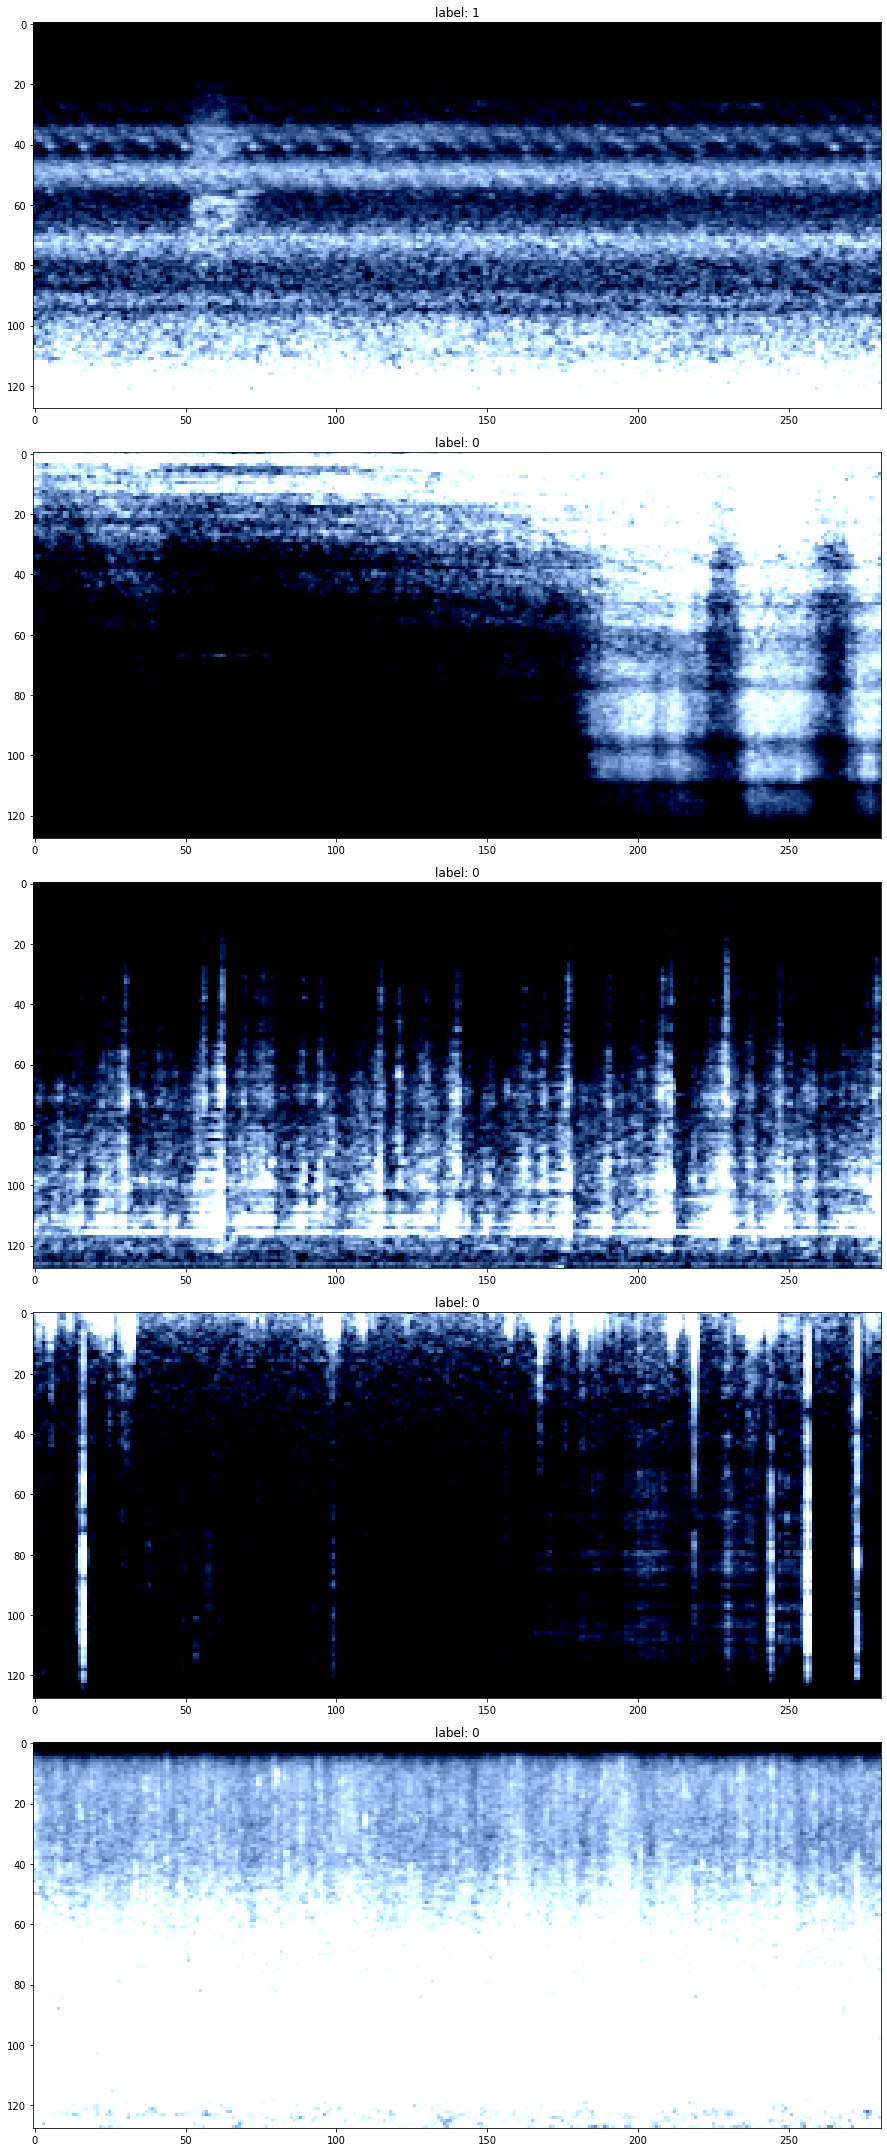

In [12]:
train_dataset = TrainDataset(train, 
                             transform=get_transforms(data='train'))


fig,ax = plt.subplots(5,1,figsize=(15,30))
for i,ax1 in enumerate(ax):
    i += np.random.randint(low=0,high = 1500)
    image, label = train_dataset[i]
    
    
    # reshape for visualization (from depth * height * width -> height*width * depth)
    im = np.zeros(shape = (CFG.dim[0],CFG.dim[1],3))  
    im[:,:,0] = image[0]
    im[:,:,1] = image[1]
    im[:,:,2] = image[2]
    
    ax1.imshow(im,cmap='jet')
    ax1.set_title(f'label: {label}')

plt.tight_layout()    
plt.show() 

# **Model**

In [13]:


class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
def get_scheduler(optimizer):
    '''cosine annealing scheduler'''
    scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                            T_0=CFG.T_0, 
                                            T_mult=1, 
                                            eta_min=CFG.min_lr, 
                                            last_epoch=-1)
    return scheduler


**Training and validation Functions**

In [15]:

def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    '''perform training on one epoch of data.'''
    
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    
        
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        #load data
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        #forward pass
        y_preds = model(images)
        
        #calculate loss
        loss = criterion(y_preds, labels)
        
        
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
            
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    '''perform validation'''
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        
        
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    '''inference'''
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

**Training Procedure / loop**

In [16]:

def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, 
                            model, 
                            criterion, 
                            optimizer, 
                            epoch, 
                            scheduler, 
                            CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy(validation): {score}')
        
        scores.append(score)
        
        
        # save the model weights with the best score 
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores



In [17]:
def get_result(result_df):
    
    preds = result_df['preds'].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.5f}')

def get_confusion_mat(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG.target_col].values
    matrix = get_confusion_matrix(labels, preds)
    print('TN', matrix[0,0])
    print('FP', matrix[0,1])
    print('FN', matrix[1,0])
    print('TP', matrix[1,1])


In [18]:


def main(fold):
    '''run training on the dataset, with validation on the input fold'''
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    
    
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_confusion_mat(oof_df)
    
    
    
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()



# Training

**Training with fold 5 as the validation set**

========== training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_a1h-0146ab0a.pth


Epoch: [1][1/192] Data 1.235 (1.235) Elapsed 0m 9s (remain 29m 8s) Loss: 0.7159(0.7159) Grad: 33.8286  
Epoch: [1][51/192] Data 0.001 (0.025) Elapsed 0m 24s (remain 1m 8s) Loss: 0.6218(0.5914) Grad: 27.4069  
Epoch: [1][101/192] Data 0.001 (0.013) Elapsed 0m 41s (remain 0m 36s) Loss: 0.4708(0.5450) Grad: 19.8561  
Epoch: [1][151/192] Data 0.001 (0.009) Elapsed 0m 56s (remain 0m 15s) Loss: 0.3004(0.5088) Grad: 16.3372  
Epoch: [1][192/192] Data 0.000 (0.007) Elapsed 1m 9s (remain 0m 0s) Loss: 0.4777(0.4791) Grad: 19.3967  
EVAL: [1/49] Data 0.606 (0.606) Elapsed 0m 0s (remain 0m 32s) Loss: 0.5095(0.5095) 


Epoch 1 - avg_train_loss: 0.4791  avg_val_loss: 0.3233  time: 76s
Epoch 1 - Accuracy(validation): 0.8751625487646294
Epoch 1 - Save Best Score: 0.8752 Model


EVAL: [49/49] Data 0.000 (0.045) Elapsed 0m 5s (remain 0m 0s) Loss: 0.1553(0.3233) 
Epoch: [2][1/192] Data 0.847 (0.847) Elapsed 0m 1s (remain 3m 48s) Loss: 0.2606(0.2606) Grad: 9.8490  
Epoch: [2][51/192] Data 0.001 (0.017) Elapsed 0m 17s (remain 0m 47s) Loss: 0.4518(0.3760) Grad: 30.5604  
Epoch: [2][101/192] Data 0.000 (0.009) Elapsed 0m 32s (remain 0m 29s) Loss: 0.4276(0.3658) Grad: 25.1216  
Epoch: [2][151/192] Data 0.001 (0.006) Elapsed 0m 48s (remain 0m 13s) Loss: 0.2303(0.3548) Grad: 8.1965  
Epoch: [2][192/192] Data 0.000 (0.005) Elapsed 1m 1s (remain 0m 0s) Loss: 0.4110(0.3444) Grad: 16.5663  
EVAL: [1/49] Data 0.492 (0.492) Elapsed 0m 0s (remain 0m 27s) Loss: 0.5125(0.5125) 


Epoch 2 - avg_train_loss: 0.3444  avg_val_loss: 0.2919  time: 66s
Epoch 2 - Accuracy(validation): 0.88296488946684
Epoch 2 - Save Best Score: 0.8830 Model


EVAL: [49/49] Data 0.000 (0.011) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0752(0.2919) 
Epoch: [3][1/192] Data 0.990 (0.990) Elapsed 0m 1s (remain 4m 16s) Loss: 0.2542(0.2542) Grad: 10.8973  
Epoch: [3][51/192] Data 0.001 (0.021) Elapsed 0m 17s (remain 0m 47s) Loss: 0.4088(0.3321) Grad: 18.1405  
Epoch: [3][101/192] Data 0.000 (0.011) Elapsed 0m 32s (remain 0m 29s) Loss: 0.4687(0.3201) Grad: 32.1065  
Epoch: [3][151/192] Data 0.000 (0.007) Elapsed 0m 48s (remain 0m 13s) Loss: 0.2143(0.3090) Grad: 11.3721  
Epoch: [3][192/192] Data 0.000 (0.006) Elapsed 1m 1s (remain 0m 0s) Loss: 0.4508(0.2999) Grad: 20.7490  
EVAL: [1/49] Data 0.373 (0.373) Elapsed 0m 0s (remain 0m 23s) Loss: 0.4494(0.4494) 


Epoch 3 - avg_train_loss: 0.2999  avg_val_loss: 0.2816  time: 66s
Epoch 3 - Accuracy(validation): 0.8855656697009102
Epoch 3 - Save Best Score: 0.8856 Model


EVAL: [49/49] Data 0.000 (0.009) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0653(0.2816) 
Epoch: [4][1/192] Data 1.026 (1.026) Elapsed 0m 1s (remain 4m 31s) Loss: 0.2438(0.2438) Grad: 10.3107  
Epoch: [4][51/192] Data 0.000 (0.021) Elapsed 0m 17s (remain 0m 47s) Loss: 0.4120(0.3141) Grad: 21.4537  
Epoch: [4][101/192] Data 0.001 (0.011) Elapsed 0m 33s (remain 0m 29s) Loss: 0.3472(0.3020) Grad: 16.3169  
Epoch: [4][151/192] Data 0.001 (0.008) Elapsed 0m 48s (remain 0m 13s) Loss: 0.1515(0.2880) Grad: 10.4039  
Epoch: [4][192/192] Data 0.000 (0.006) Elapsed 1m 1s (remain 0m 0s) Loss: 0.4037(0.2759) Grad: 16.9610  
EVAL: [1/49] Data 0.500 (0.500) Elapsed 0m 0s (remain 0m 28s) Loss: 0.4445(0.4445) 


Epoch 4 - avg_train_loss: 0.2759  avg_val_loss: 0.2765  time: 66s
Epoch 4 - Accuracy(validation): 0.8959687906371911
Epoch 4 - Save Best Score: 0.8960 Model


EVAL: [49/49] Data 0.000 (0.016) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0368(0.2765) 
Epoch: [5][1/192] Data 1.047 (1.047) Elapsed 0m 1s (remain 4m 32s) Loss: 0.2305(0.2305) Grad: 10.6680  
Epoch: [5][51/192] Data 0.001 (0.022) Elapsed 0m 17s (remain 0m 48s) Loss: 0.3586(0.2835) Grad: 15.5910  
Epoch: [5][101/192] Data 0.000 (0.012) Elapsed 0m 33s (remain 0m 30s) Loss: 0.2635(0.2733) Grad: 14.4359  
Epoch: [5][151/192] Data 0.000 (0.008) Elapsed 0m 49s (remain 0m 13s) Loss: 0.1423(0.2590) Grad: 8.7193  
Epoch: [5][192/192] Data 0.000 (0.006) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3672(0.2501) Grad: 17.6618  
EVAL: [1/49] Data 0.528 (0.528) Elapsed 0m 0s (remain 0m 30s) Loss: 0.4518(0.4518) 


Epoch 5 - avg_train_loss: 0.2501  avg_val_loss: 0.2750  time: 67s
Epoch 5 - Accuracy(validation): 0.8940182054616385


EVAL: [49/49] Data 0.000 (0.013) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0337(0.2750) 
Epoch: [6][1/192] Data 0.993 (0.993) Elapsed 0m 1s (remain 4m 20s) Loss: 0.1917(0.1917) Grad: 7.6913  
Epoch: [6][51/192] Data 0.001 (0.020) Elapsed 0m 17s (remain 0m 47s) Loss: 0.4725(0.2806) Grad: 25.4130  
Epoch: [6][101/192] Data 0.000 (0.011) Elapsed 0m 33s (remain 0m 29s) Loss: 0.3517(0.2791) Grad: 18.9776  
Epoch: [6][151/192] Data 0.000 (0.008) Elapsed 0m 48s (remain 0m 13s) Loss: 0.1692(0.2766) Grad: 10.5046  
Epoch: [6][192/192] Data 0.000 (0.006) Elapsed 1m 1s (remain 0m 0s) Loss: 0.4502(0.2688) Grad: 26.3696  
EVAL: [1/49] Data 0.556 (0.556) Elapsed 0m 0s (remain 0m 30s) Loss: 0.4300(0.4300) 


Epoch 6 - avg_train_loss: 0.2688  avg_val_loss: 0.2890  time: 66s
Epoch 6 - Accuracy(validation): 0.8959687906371911


EVAL: [49/49] Data 0.000 (0.014) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0875(0.2890) 
Epoch: [7][1/192] Data 0.838 (0.838) Elapsed 0m 1s (remain 4m 1s) Loss: 0.1989(0.1989) Grad: 11.0702  
Epoch: [7][51/192] Data 0.000 (0.017) Elapsed 0m 17s (remain 0m 48s) Loss: 0.2874(0.2650) Grad: 15.1800  
Epoch: [7][101/192] Data 0.000 (0.009) Elapsed 0m 33s (remain 0m 30s) Loss: 0.2851(0.2566) Grad: 16.9148  
Epoch: [7][151/192] Data 0.000 (0.006) Elapsed 0m 49s (remain 0m 13s) Loss: 0.1135(0.2535) Grad: 6.2450  
Epoch: [7][192/192] Data 0.000 (0.005) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2698(0.2450) Grad: 15.3410  
EVAL: [1/49] Data 0.492 (0.492) Elapsed 0m 0s (remain 0m 27s) Loss: 0.5145(0.5145) 


Epoch 7 - avg_train_loss: 0.2450  avg_val_loss: 0.2731  time: 67s
Epoch 7 - Accuracy(validation): 0.8972691807542262
Epoch 7 - Save Best Score: 0.8973 Model


EVAL: [49/49] Data 0.000 (0.011) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0601(0.2731) 
Epoch: [8][1/192] Data 0.974 (0.974) Elapsed 0m 1s (remain 4m 13s) Loss: 0.1679(0.1679) Grad: 11.0263  
Epoch: [8][51/192] Data 0.000 (0.020) Elapsed 0m 17s (remain 0m 48s) Loss: 0.3630(0.2299) Grad: 16.3076  
Epoch: [8][101/192] Data 0.000 (0.011) Elapsed 0m 33s (remain 0m 30s) Loss: 0.1621(0.2194) Grad: 12.4148  
Epoch: [8][151/192] Data 0.001 (0.007) Elapsed 0m 48s (remain 0m 13s) Loss: 0.1585(0.2157) Grad: 10.9715  
Epoch: [8][192/192] Data 0.000 (0.006) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2847(0.2072) Grad: 15.4211  
EVAL: [1/49] Data 0.452 (0.452) Elapsed 0m 0s (remain 0m 25s) Loss: 0.6532(0.6532) 


Epoch 8 - avg_train_loss: 0.2072  avg_val_loss: 0.2908  time: 67s
Epoch 8 - Accuracy(validation): 0.8953185955786735


EVAL: [49/49] Data 0.000 (0.011) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0589(0.2908) 
Epoch: [9][1/192] Data 1.130 (1.130) Elapsed 0m 1s (remain 4m 44s) Loss: 0.1426(0.1426) Grad: 8.1724  
Epoch: [9][51/192] Data 0.001 (0.023) Elapsed 0m 17s (remain 0m 48s) Loss: 0.2513(0.2087) Grad: 13.7690  
Epoch: [9][101/192] Data 0.001 (0.012) Elapsed 0m 33s (remain 0m 30s) Loss: 0.2500(0.1922) Grad: 15.8234  
Epoch: [9][151/192] Data 0.001 (0.008) Elapsed 0m 49s (remain 0m 13s) Loss: 0.0895(0.1815) Grad: 6.2245  
Epoch: [9][192/192] Data 0.000 (0.007) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1628(0.1721) Grad: 15.2855  
EVAL: [1/49] Data 0.438 (0.438) Elapsed 0m 0s (remain 0m 24s) Loss: 0.6109(0.6109) 


Epoch 9 - avg_train_loss: 0.1721  avg_val_loss: 0.2903  time: 67s
Epoch 9 - Accuracy(validation): 0.9018205461638491
Epoch 9 - Save Best Score: 0.9018 Model


EVAL: [49/49] Data 0.000 (0.010) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0829(0.2903) 
Epoch: [10][1/192] Data 1.298 (1.298) Elapsed 0m 1s (remain 5m 18s) Loss: 0.0949(0.0949) Grad: 7.2467  
Epoch: [10][51/192] Data 0.000 (0.026) Elapsed 0m 17s (remain 0m 49s) Loss: 0.2102(0.1699) Grad: 13.9613  
Epoch: [10][101/192] Data 0.000 (0.014) Elapsed 0m 33s (remain 0m 30s) Loss: 0.2546(0.1602) Grad: 19.1297  
Epoch: [10][151/192] Data 0.000 (0.009) Elapsed 0m 49s (remain 0m 13s) Loss: 0.0460(0.1524) Grad: 2.8175  
Epoch: [10][192/192] Data 0.000 (0.008) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1668(0.1484) Grad: 11.8247  
EVAL: [1/49] Data 0.464 (0.464) Elapsed 0m 0s (remain 0m 26s) Loss: 0.6304(0.6304) 


Epoch 10 - avg_train_loss: 0.1484  avg_val_loss: 0.2990  time: 67s
Epoch 10 - Accuracy(validation): 0.8972691807542262


EVAL: [49/49] Data 0.000 (0.010) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0593(0.2990) 
Epoch: [11][1/192] Data 1.176 (1.176) Elapsed 0m 1s (remain 4m 56s) Loss: 0.1390(0.1390) Grad: 9.4213  
Epoch: [11][51/192] Data 0.000 (0.024) Elapsed 0m 17s (remain 0m 48s) Loss: 0.2765(0.1695) Grad: 14.1243  
Epoch: [11][101/192] Data 0.001 (0.013) Elapsed 0m 33s (remain 0m 30s) Loss: 0.2589(0.1846) Grad: 20.3752  
Epoch: [11][151/192] Data 0.000 (0.009) Elapsed 0m 49s (remain 0m 13s) Loss: 0.0973(0.1853) Grad: 8.8896  
Epoch: [11][192/192] Data 0.000 (0.007) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4652(0.1811) Grad: 25.9015  
EVAL: [1/49] Data 0.408 (0.408) Elapsed 0m 0s (remain 0m 24s) Loss: 0.5680(0.5680) 


Epoch 11 - avg_train_loss: 0.1811  avg_val_loss: 0.2924  time: 67s
Epoch 11 - Accuracy(validation): 0.8946684005201561


EVAL: [49/49] Data 0.000 (0.009) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0268(0.2924) 
Epoch: [12][1/192] Data 0.939 (0.939) Elapsed 0m 1s (remain 4m 14s) Loss: 0.1538(0.1538) Grad: 11.0536  
Epoch: [12][51/192] Data 0.001 (0.020) Elapsed 0m 17s (remain 0m 48s) Loss: 0.3851(0.1835) Grad: 19.1629  
Epoch: [12][101/192] Data 0.000 (0.010) Elapsed 0m 33s (remain 0m 29s) Loss: 0.1459(0.1769) Grad: 15.1576  
Epoch: [12][151/192] Data 0.001 (0.007) Elapsed 0m 48s (remain 0m 13s) Loss: 0.0550(0.1700) Grad: 4.1796  
Epoch: [12][192/192] Data 0.000 (0.006) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1841(0.1629) Grad: 11.7523  
EVAL: [1/49] Data 0.412 (0.412) Elapsed 0m 0s (remain 0m 23s) Loss: 0.6157(0.6157) 


Epoch 12 - avg_train_loss: 0.1629  avg_val_loss: 0.2973  time: 66s
Epoch 12 - Accuracy(validation): 0.9050715214564369
Epoch 12 - Save Best Score: 0.9051 Model


EVAL: [49/49] Data 0.000 (0.009) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0677(0.2973) 
Epoch: [13][1/192] Data 0.993 (0.993) Elapsed 0m 1s (remain 4m 28s) Loss: 0.0942(0.0942) Grad: 8.7818  
Epoch: [13][51/192] Data 0.000 (0.021) Elapsed 0m 17s (remain 0m 48s) Loss: 0.4579(0.1559) Grad: 22.8782  
Epoch: [13][101/192] Data 0.001 (0.011) Elapsed 0m 33s (remain 0m 29s) Loss: 0.1894(0.1417) Grad: 11.2335  
Epoch: [13][151/192] Data 0.000 (0.007) Elapsed 0m 48s (remain 0m 13s) Loss: 0.0635(0.1340) Grad: 5.0443  
Epoch: [13][192/192] Data 0.000 (0.006) Elapsed 1m 1s (remain 0m 0s) Loss: 0.2480(0.1282) Grad: 15.8341  
EVAL: [1/49] Data 0.377 (0.377) Elapsed 0m 0s (remain 0m 21s) Loss: 0.6208(0.6208) 


Epoch 13 - avg_train_loss: 0.1282  avg_val_loss: 0.3154  time: 66s
Epoch 13 - Accuracy(validation): 0.8998699609882965


EVAL: [49/49] Data 0.000 (0.009) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1007(0.3154) 
Epoch: [14][1/192] Data 1.055 (1.055) Elapsed 0m 1s (remain 4m 37s) Loss: 0.0658(0.0658) Grad: 5.1715  
Epoch: [14][51/192] Data 0.001 (0.022) Elapsed 0m 17s (remain 0m 48s) Loss: 0.2222(0.1206) Grad: 14.0303  
Epoch: [14][101/192] Data 0.000 (0.012) Elapsed 0m 33s (remain 0m 29s) Loss: 0.2303(0.1182) Grad: 23.9904  
Epoch: [14][151/192] Data 0.001 (0.008) Elapsed 0m 48s (remain 0m 13s) Loss: 0.0604(0.1084) Grad: 7.0532  
Epoch: [14][192/192] Data 0.000 (0.006) Elapsed 1m 1s (remain 0m 0s) Loss: 0.0773(0.1008) Grad: 11.3259  
EVAL: [1/49] Data 0.431 (0.431) Elapsed 0m 0s (remain 0m 24s) Loss: 0.6469(0.6469) 


Epoch 14 - avg_train_loss: 0.1008  avg_val_loss: 0.3266  time: 66s
Epoch 14 - Accuracy(validation): 0.8972691807542262


EVAL: [49/49] Data 0.000 (0.011) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1455(0.3266) 
Epoch: [15][1/192] Data 1.056 (1.056) Elapsed 0m 1s (remain 4m 44s) Loss: 0.0714(0.0714) Grad: 8.2020  
Epoch: [15][51/192] Data 0.000 (0.022) Elapsed 0m 17s (remain 0m 47s) Loss: 0.2848(0.0959) Grad: 14.7269  
Epoch: [15][101/192] Data 0.000 (0.011) Elapsed 0m 33s (remain 0m 29s) Loss: 0.0941(0.0932) Grad: 8.8125  
Epoch: [15][151/192] Data 0.000 (0.008) Elapsed 0m 48s (remain 0m 13s) Loss: 0.0335(0.0870) Grad: 4.2845  
Epoch: [15][192/192] Data 0.000 (0.006) Elapsed 1m 1s (remain 0m 0s) Loss: 0.0325(0.0824) Grad: 2.5668  
EVAL: [1/49] Data 0.438 (0.438) Elapsed 0m 0s (remain 0m 26s) Loss: 0.6317(0.6317) 


Epoch 15 - avg_train_loss: 0.0824  avg_val_loss: 0.3294  time: 66s
Epoch 15 - Accuracy(validation): 0.8992197659297789


EVAL: [49/49] Data 0.000 (0.010) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1650(0.3294) 


========== CV ==========
Score: 0.90507


TN 1119
FP 32
FN 114
TP 273


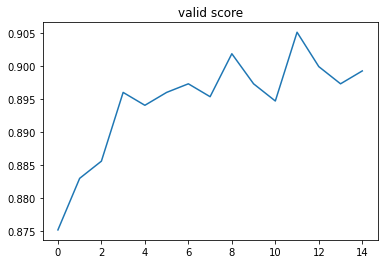

In [19]:
if __name__ == '__main__':
    main(0)

**We can use the saved model on the birdclef spectrograms to filter out the no-bird calls for training.**